## Phoenix BII Analysis
- Author: Zoe Zhou
- [Link to github repo](https://github.com/ZoeZhouJ/urban-bii-analysis)
- Course Website: [EDS 220](https://meds-eds-220.github.io/MEDS-eds-220-course/assignments/final-project.html)

## About 

**Purpose**: This project analyzes changes in the Biodiversity Intactness Index (BII) in Phoenix, Arizona (Maricopa County) between 2017 and 2020. The analysis aims to understand the impact of urban expansion on local biodiversity, as Phoenix has experienced significant urban development in recent decades.

**Highlights:**
- **Data Exploration**: Accessing and extracting geospatial data through the `pystac_client` API,focusing on specific collections and spatial extents. Implementing raster data processing using `rioxarray`. 

- **Temporal BII Analysis**: Analyzing changes in the Biodiversity Intactness Index (BII) across Phoenix from 2017 to 2020, with particular emphasis on areas maintaining high biodiversity values (BII ≥ 0.75). Quantifying percentage changes to measure the impact of urban development on local ecosystems.

- **Spatial Visualization**: Developing comprehensive visualizations using multiple data layers to illustrate biodiversity changes. Combining vector and raster datasets to create informative maps that highlight areas of significant BII loss.

**About the data**: 

This study utilizes two primary datasets to analyze biodiversity changes in Phoenix. The Biodiversity Intactness Index (BII) data is sourced from [Microsoft Planetary Computer's STAC catalog's](https://planetarycomputer.microsoft.com/dataset/io-biodiversity) `io-biodiversity` collection, specifically focusing on temporal changes between 2017 and 2020. The analysis area is defined by a bounding box with coordinates [-112.826843, 32.974108, -111.184387, 33.863574] encompassing the Phoenix metropolitan region. The study area boundaries are defined using the Phoenix subdivision shapefile, obtained from the [2020 TIGER/Line® Shapefiles](https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2020&layergroup=County+Subdivisions) published by the US Census Bureau, which provides detailed county subdivision boundaries for Arizona.

**Source:** 

Microsoft Open Source, Matt McFarland, Rob Emanuele, Dan Morris, & Tom Augspurger. (2022). microsoft/PlanetaryComputer: October 2022 (2022.10.28). Zenodo. https://doi.org/10.5281/zenodo.7261897 Accessed: 2024-12-02

2020 TIGER/Line Shapefiles (machinereadable data files) / prepared by the U.S. Census Bureau, 2020 https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2020&layergroup=County+Subdivisions Accessed: 2024-12-02

### Set Up 
We will use the following libraries and set-up through this analysis

In [8]:
# Import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # To plot the final figure
import matplotlib.pyplot as mlines # To add legend to final figure
import geopandas as gpd # To work with shapefiles
import rioxarray as rioxr # To work with rasters
import contextily as ctx # To add a basemap

from pystac_client import Client # To access STAC catalogs

import planetary_computer # To sign items from the MPC STAC catalog

from IPython.display import Image # To nicely display images

# Set option to display all columns
pd.set_option('display.max_columns', None)

### Preliminary Data Exploration

1. Before retriveing any data, update .gitignore with the entire data directory for best version control efficiency. 

2. Download and import TIGER county subdivisons shapefile for Arizona in 2020. 

3. Add a base map from the `contextily` package

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

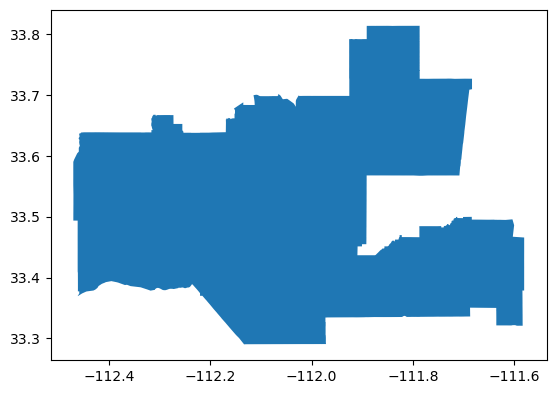

In [27]:
# Load boundary data
arizona = gpd.read_file(os.path.join('./data/','tl_2020_04_cousub.shp'))
arizona.head()

# Filter for Phoenix
phoenix = arizona[arizona['NAME'] == 'Phoenix'] 
phoenix.head()

# Get general information about data
phoenix.plot()
phoenix.crs

**Date Summary**:
The 2020 TIGER/Line Arizona County Subdivisions dataset provides detailed administrative boundary information for the 61 county subdivisions in Arizona. It is available as a GeoDataFrame containing multiple attributes including geographic identifiers (GEOID), names, legal/statistical area descriptions, and precise boundary geometries. The dataset uses the NAD83 (EPSG:4269) coordinate system and is updated annually as part of the U.S. Census Bureau's TIGER/Line program. 

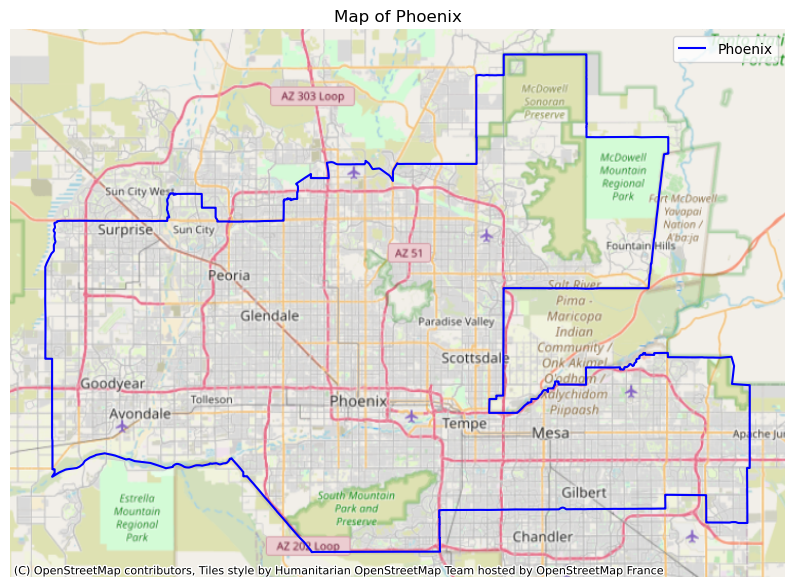

In [19]:
# Plot Phoenix area together with a base map

# Initialize figure
fig, ax = plt.subplots(figsize =(10, 10))

# Plot city boundary
phoenix.boundary.plot(ax=ax,
                     color='blue')
# Add base map
ctx.add_basemap(ax=ax, crs=phoenix.crs)

# Clean map
ax.set_title('Map of Phoenix')
ax.axis('off')
ax.legend(phoenix['NAME'])

plt.show()

In [36]:
# Save file as GeoJSON for reproducibility
phoenix.to_file('data_clean/phoenix-boundary-file', driver='GeoJSON')

4. Access BII data from MPC

**Workflow:**
- Define bounding box and time range for search 
- Open MPC catalog 
- Search MPC catalog for `io_biodiversity` collection with bounding box and time_range
- Retrive search items 
- Select unique search item 
- examine `item.assets` keys and title
- display pre-rendered image

In [61]:
# Define study extent and time range
# Define study extent and time range
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]
time_range = "2017-01-01/2020-01-01"

# Access MPC catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Search for collection 
search = catalog.search(
    collections=['io-biodiversity'],
    bbox=bbox,
    datetime=time_range)
search

# Retrieve items
items = search.item_collection()
items
# Determine number of items in search
print(f'There are {len(items)} items in the search.')

There are 4 items in the search.


In [64]:
item=items[0]
# Check assets in item 
for key in item.assets.keys():
    print(key, '--', item.assets[key].title)

data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview


In [65]:
# Plot rendered preview
Image(url=item.assets['rendered_preview'].href, width=500)

Looks like 

## Clip raster to geometry 
